# Analyze red noise in one pulsar

In [49]:
import numpy as np
import matplotlib.pyplot as plt

from jax import config
import jax.numpy as jnp
import jax.random as jr

import numpyro
import numpyro.distributions as dist

# use double precision
config.update('jax_enable_x64', True)

import sys
import os
sys.path.append(os.path.abspath('..'))

from PTA import PTA
from likelihood import get_likelihood_obj
from samples import Samples

import torch
from torch import tensor
import zuko
import random

import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulate data

In [2]:
# make PTA detector and model
pta = PTA(Np=1,  # number of pulsars
          Tspan_yr=15.,  # observation time span
          Nf=30,  # number of frequency bins to inject / model
          model_wn=True,  # model white noise (EFAC)
          model_rn=False,  # model intrinsic pulsar red noise
          model_gwb=True,  # model gravitational wave background
          model_cw=False,  # model continuous wave
          gwb_free_spectral=True,  # free spectral model
          efacs_inj=jnp.array([1.0]),  # injected EFAC value
          gwb_power_law_inj=jnp.array([-13.4, 3.2]),  # injected power law parameters
          seed=0,  # random seed for simulation
          )

# likelihood object
l = get_likelihood_obj(pta)

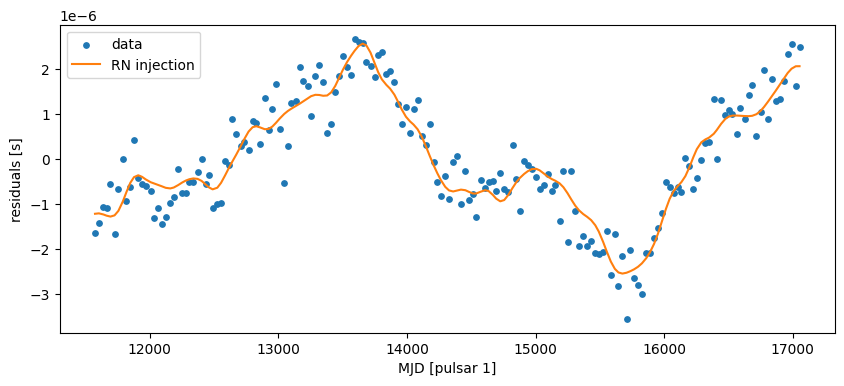

In [3]:
# plot data and injected signals
psr_ndx = 0
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.residuals[psr_ndx], color='C0', s=15, label='data')
rn_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
plt.plot(pta.MJDs[psr_ndx], rn_residuals_inj, color='C1', label='RN injection')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()

## Sample posterior

In [4]:
# kernel
def sampling_model():
    # uniform prior on hyper-parameters
    efacs = numpyro.sample('efacs', dist.Uniform(pta.efac_mins, pta.efac_maxs))
    gwb_hypers = numpyro.sample('gwb_hypers', dist.Uniform(pta.gwb_mins, pta.gwb_maxs))

    # normal prior on Fourier coefficients
    a_standard = numpyro.sample('a_standard', dist.Normal().expand([pta.Na]))
    a_transformed = jnp.repeat(jnp.sqrt(10. ** gwb_hypers), 2) * a_standard
    a = numpyro.deterministic('a', a_transformed)

    # likelihood
    numpyro.factor('ln_likelihood', l.lnlike(efacs, a))

In [5]:
# sample with NumPyro NUTS
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 dense_mass=True)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(2e6))
mcmc.run(jr.key(3))
samples_dict = mcmc.get_samples()

sample: 100%|██████████| 2010000/2010000 [35:40<00:00, 938.85it/s, 63 steps of size 4.29e-02. acc. prob=0.83]   


## Post-processing

In [34]:
# convert samples dictionary into numpy array
samples_arr = np.concatenate((samples_dict['efacs'],
                              samples_dict['gwb_hypers'],
                              samples_dict['a'],
                              ), axis=1)

# make samples object for post-processing
samples = Samples(samples_arr=samples_arr,
                  labels=pta.x_labels,
                  x_inj=pta.x_inj)

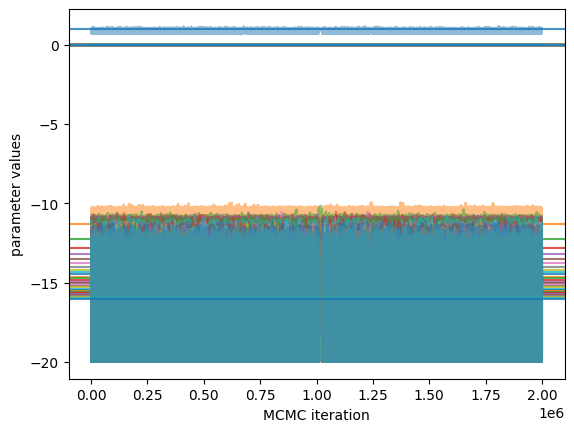

In [35]:
# plot parameter values over MCMC samples
samples.trace_plt(legend=False)

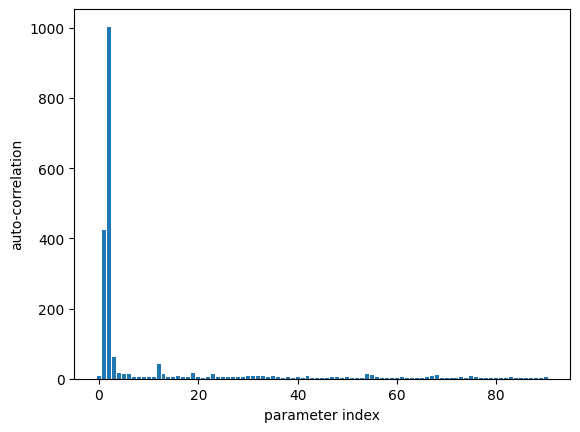

In [36]:
# plot auto-correlation length of parameters
samples.plt_auto_corr()

Parameter $\log_{10}\,\rho^{6}_B$ in chain samples is not constrained


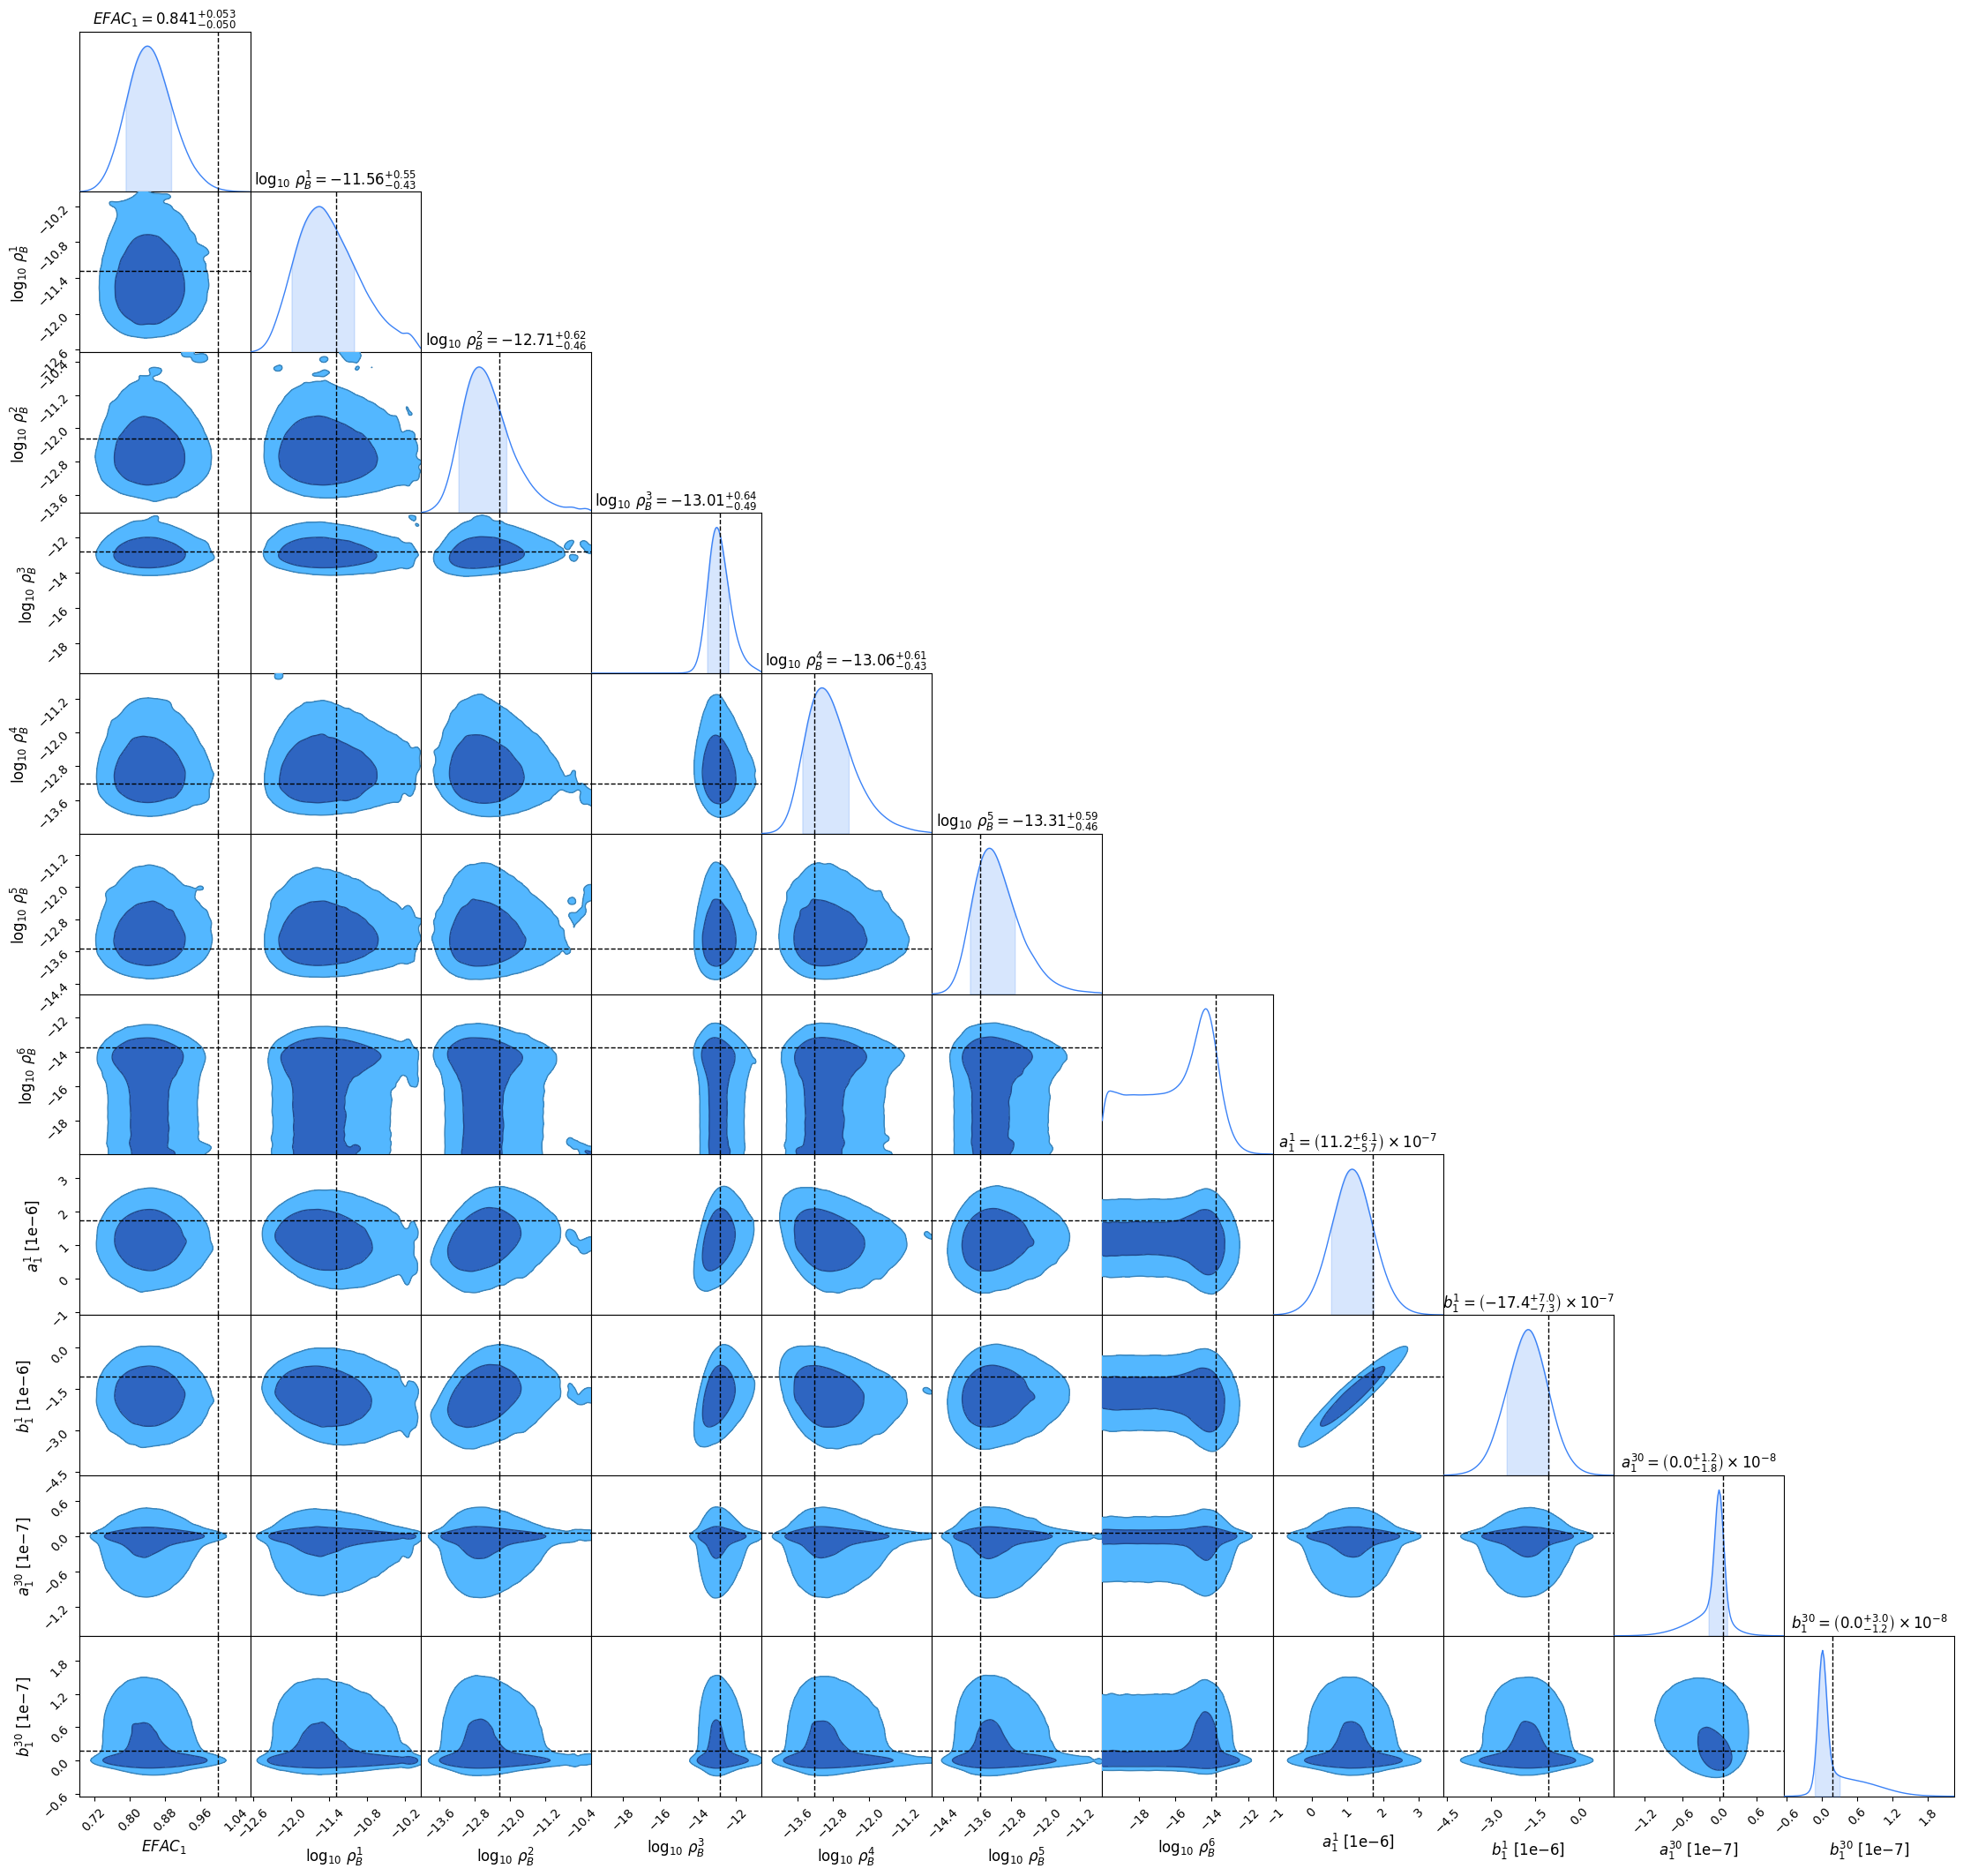

In [37]:
# indices of parameters to plot
ndxs = np.concatenate((pta.efac_ndxs,
                       pta.gwb_ndxs[:6],
                       pta.a_ndxs[:2],
                       pta.a_ndxs[-2:]))
# corner plot
samples.corner_plt(param_ndxs=ndxs, color='blue')

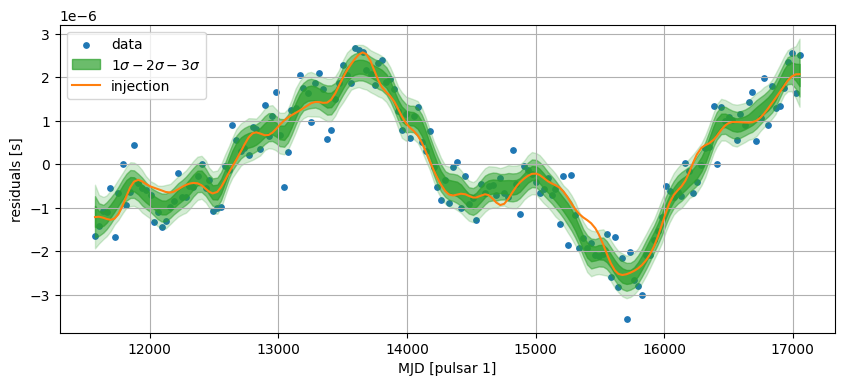

In [38]:
# Bayesogram
psr_ndx = 0
fair_draw_ndxs = np.random.choice(samples_arr.shape[0], (10_000,))

# percentile layers for plotting densities of samples
percentile_layers = [0.15, 2.5, 16.]
alphas = [0.2, 0.5, 0.7]

# plot data, samples, and injected signals
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.residuals[psr_ndx], color='C0', s=15, label='data')

rn_gwb_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ samples_arr[ndx, pta.a_ndxs].reshape((pta.Np, pta.Na))[psr_ndx]
                           for ndx in fair_draw_ndxs])
for percentile, alpha in zip(percentile_layers, alphas):
    if percentile != percentile_layers[-1]:
        plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                        np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                        color='C2', alpha=alpha)
    else:
        plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                        np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                        color='C2', alpha=alpha, label=r'$1\sigma-2\sigma-3\sigma$')
rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ rn_gwb_residuals_inj, color='C1', label='injection')

plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.grid()
plt.show()

In [39]:
free_spectral_samples = samples.samples[:, pta.gwb_ndxs]

In [42]:
# transformation to normalize samples
B = 4
max_val = jnp.max(free_spectral_samples, axis=0)
min_val = jnp.min(free_spectral_samples, axis=0)
h = (max_val - min_val) / 2
mean_val = (max_val + min_val) / 2

def normalize(sample):
    return B * (sample - mean_val[None]) / h[None]

def unnormalize(sample):
    return sample * h[None] / B + mean_val[None]

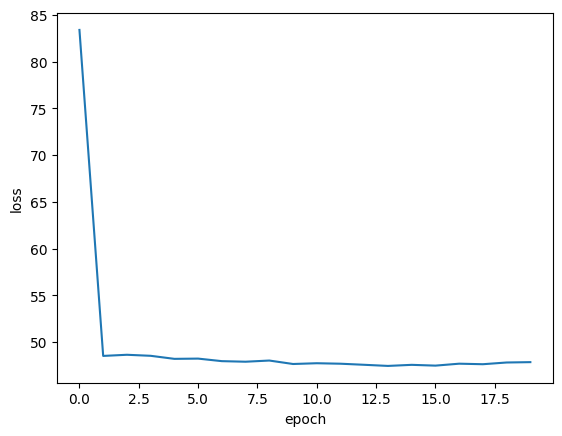

In [44]:
torch.set_default_dtype(torch.float64)

# define flow
flow = zuko.flows.spline.NSF(features=pta.Nf,
                             context=0,
                             bins=8,
                             passes=2,
                             hidden_features=[512] * 4)

normalized_samples = torch.tensor(normalize(free_spectral_samples),
                                  device='cpu',
                                  dtype=torch.float64)
batch_size = 512
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
losses = []
num_epoch = int(1e3)
for epoch in range(num_epoch):

    idx = random.sample(range(normalized_samples.shape[0]), k=batch_size)
    fair_draws = normalized_samples[idx]

    loss = -flow().log_prob(fair_draws).mean()
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if epoch % 50 == 0:
        print(f'{np.round(epoch / num_epoch * 100, 3)}%   loss = {loss.item()}', end='\r')
        losses.append(loss.item())
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [46]:
normalized_flow_samples = flow().sample((int(2e5),))
flow_samples = unnormalize(np.array(normalized_flow_samples))

Parameter $\log_{10}\,\rho^{6}_B$ in chain HMC is not constrained
Parameter $\log_{10}\,\rho^{8}_B$ in chain normalizing flow is not constrained
Parameter $\log_{10}\,\rho^{9}_B$ in chain HMC is not constrained
Parameter $\log_{10}\,\rho^{9}_B$ in chain normalizing flow is not constrained


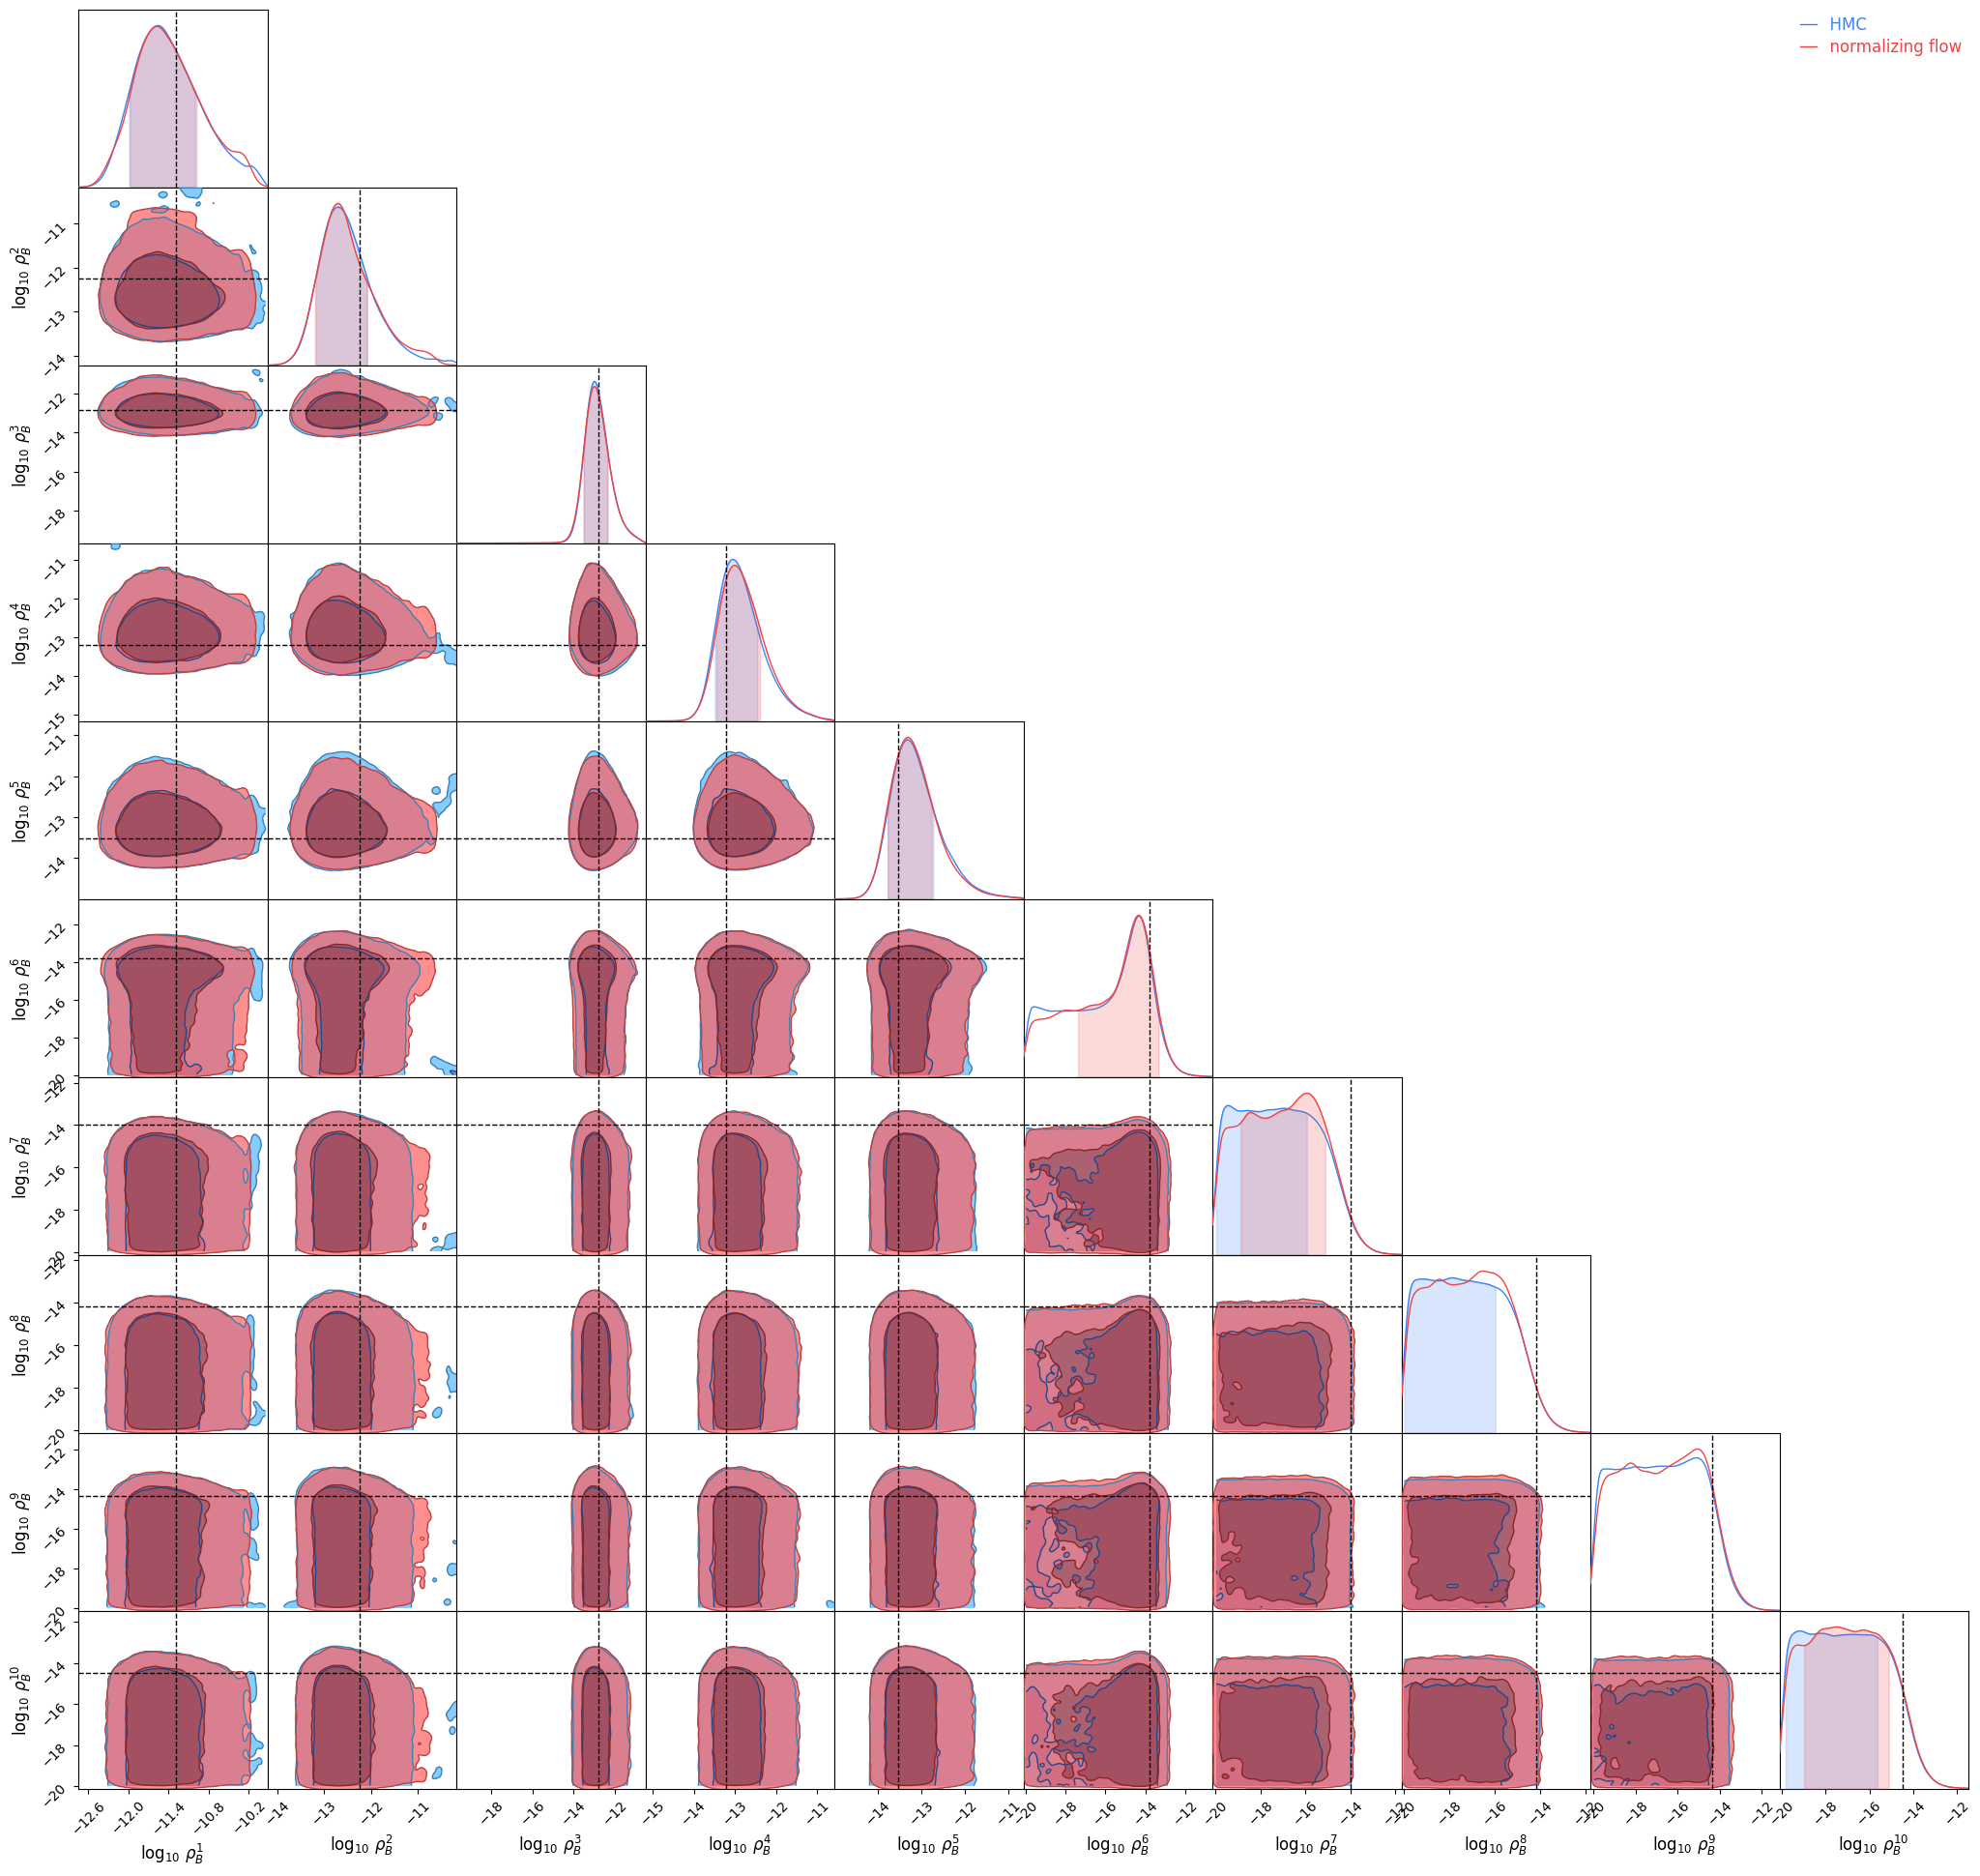

In [48]:
# corner plot
ndxs = np.r_[:10]
df_hmc = pd.DataFrame(free_spectral_samples, columns=pta.x_labels[pta.gwb_ndxs])
df_flow = pd.DataFrame(flow_samples, columns=pta.x_labels[pta.gwb_ndxs])
c = ChainConsumer()
c.add_chain(Chain(samples=df_hmc.iloc[:, ndxs], name='HMC'))
c.add_chain(Chain(samples=df_flow.iloc[:, ndxs], name='normalizing flow', color='red'))
c.add_truth(Truth(location={name: val for name, val in zip(pta.x_labels, pta.x_inj)}))
fig = c.plotter.plot()

In [29]:
from torch import tensor
flow().log_prob(tensor(pta.x_inj[pta.gwb_ndxs])).item()

-3309.6655164615245

In [52]:
hyper_mins = jnp.array([-20., 2.])
hyper_maxs = jnp.array([-10., 7.])

def second_stage_lnpost(x, temperature=1.):
    if np.any(x < hyper_mins) or np.any(x > hyper_maxs):
        return -np.inf
    else:
        log10rhos = np.log10(pta.get_rho_diag(x)[::2])
        lnlike = flow().log_prob(tensor(normalize(log10rhos))).item()
        return lnlike / temperature

In [53]:
second_stage_lnpost(pta.gwb_power_law_inj)

-50.337344968547484

In [75]:
from miscMCMC.samplers.no_jax_ptmcmc import PTMCMC

In [84]:
num_samples = int(3e6)
num_chains = 1
logpdf_func = second_stage_lnpost
ndim = 2
param_mins = hyper_mins
param_maxs = hyper_maxs

hyper_samples, hyper_lnposts, temperature_ladder = PTMCMC(num_samples,
                                                          num_chains,
                                                          logpdf_func,
                                                          ndim,
                                                          param_mins,
                                                          param_maxs,
                                                          temperature_ladder=None,
                                                          Fisher_weight=20,
                                                          DE_weight=0,
                                                          PT_swap_weight=0)

jump acceptance rates:
Fisher = [0.449]

DE = [nan]

PT = [0.]



/opt/anaconda3/envs/joint_PTA/lib/python3.10/site-packages/miscMCMC/samplers/no_jax_ptmcmc.py:141: RuntimeWarning: invalid value encountered in divide
  acceptance_rates = accept_counts / (accept_counts + reject_counts)


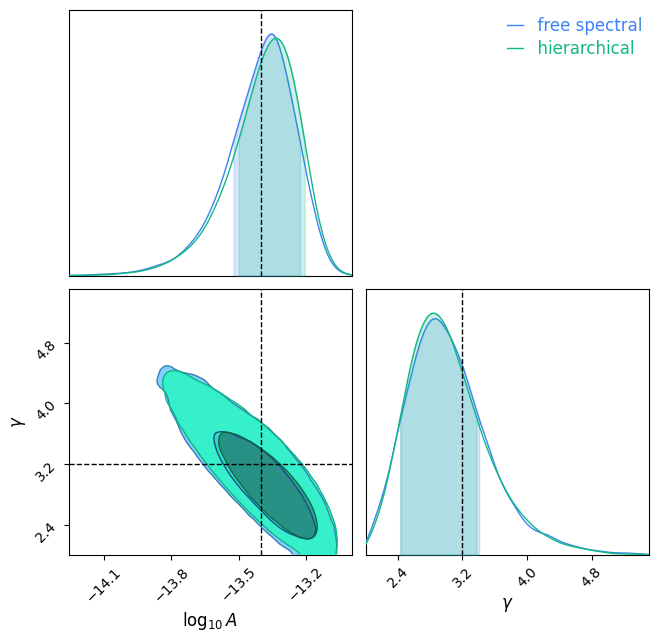

In [86]:
hyper_labels = [r'$\log_{{{10}}} A$', r'$\gamma$']
hypers_df = pd.DataFrame(hyper_samples[0, 10_000::10], columns=hyper_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=hypers_df, name='free spectral'))
hierarch_hyper_samples = pd.DataFrame(np.load('hyper_samples.npy'), columns=hyper_labels)
c.add_chain(Chain(samples=hierarch_hyper_samples, name='hierarchical'))
c.add_truth(Truth(location={name: val for name, val in zip(hyper_labels, pta.gwb_power_law_inj)}))
fig = c.plotter.plot()